## Take depth map of image

I want to use the received foreground mask to create a mask for the image and use it for the video stream in the future. the first block of code will be used in the future , because the model itself is defined in it

In [49]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

# read image file
file=r'E:\mphti\comp_vis\NbLKYTJSJhs.jpg'
img=cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_type = "MiDaS_small" 
# model_type = "DPT_Hybrid" 

# define model
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to(device) # move to cuda
midas.eval() # switch to predict mode
# transform image to MiDaS model
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform=midas_transforms.small_transform

Using cache found in C:\Users\Kirilll/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\Kirilll/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\Kirilll/.cache\torch\hub\intel-isl_MiDaS_master


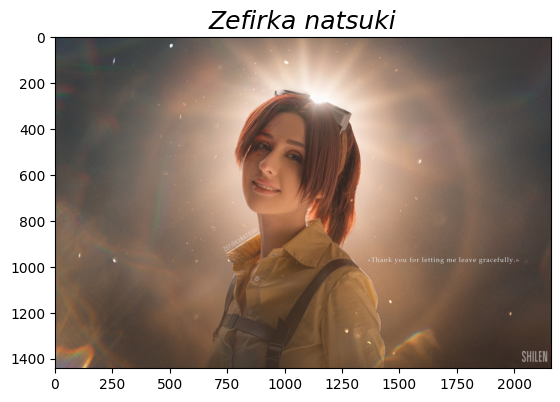

In [45]:
plt.imshow(img)
plt.title('Zefirka natsuki',fontsize=18, fontstyle='italic',)
plt.show()

In [5]:
def foreground(img,prediction,thres=0.6):
    '''
    Applies masking to the image

    Args:
        img : ndarray
        prediction: torch.Tensor
        thres: float
    Returns:
        masked_img : ndarray
    '''
    depth_map = cv2.normalize(prediction.cpu().numpy(), None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    _, mask = cv2.threshold(depth_map, thres, 1, cv2.THRESH_BINARY)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    masked_img = img*mask2[:,:,np.newaxis]
    return masked_img

In [46]:
# move to cuda img
input_img= transform(img).to(device)
# start transform
with torch.no_grad():
    predict=midas(input_img)
    # to real size
    prediction = torch.nn.functional.interpolate(
            predict.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

# use function to mask image   
masked_img=foreground(img,prediction,0.6)

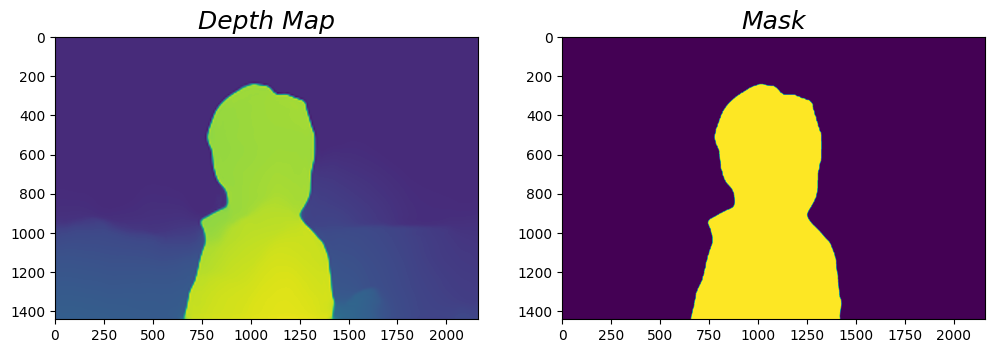

In [47]:
# Display the depth map and the mask
# move to numpy
depth_map = cv2.normalize(prediction.cpu().numpy(), None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# make mask for frontal background
_, mask = cv2.threshold(depth_map, 0.6, 1, cv2.THRESH_BINARY)
# show
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6))
ax1.imshow(depth_map)
ax1.set_title('Depth Map', fontsize=18, fontstyle='italic', )

ax2.imshow(mask)
ax2.set_title('Mask', fontsize=18, fontstyle='italic', )
plt.show()

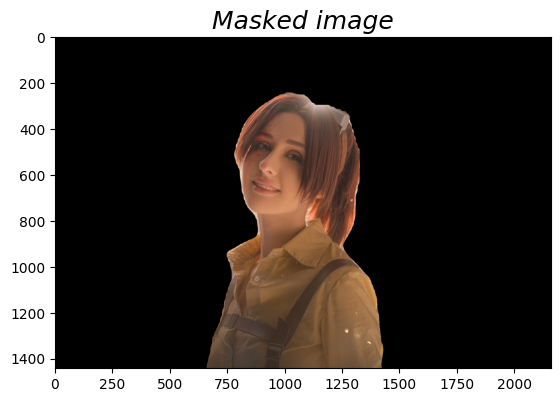

In [48]:
# we put a mask on the image
plt.imshow(masked_img)
plt.title('Masked image',fontsize=18, fontstyle='italic')
plt.show()

---

## Take depth map of video

in this block, you can get a depth map for the video and save it

In [50]:
# Open video file
cap = cv2.VideoCapture('E:\mphti\comp_vis\meee.mp4')
# Get the video properties
# in the future, we will use them to overwrite the video with the same parameters
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a VideoWriter object to write the output video
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))

while True:
    # Read a frame from the input video
    success, frame = cap.read()
    if not success:
        break

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Apply input transforms
    input_batch = transform(img).to(device)

    # Prediction and resize to original resolution
    with torch.no_grad():
        prediction = midas(input_batch)
        # to real size
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # depth_map = prediction.cpu().numpy()
    depth_map = cv2.normalize(prediction.cpu().numpy(), None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    depth_map = (depth_map*255).astype(np.uint8)
    depth_map = cv2.applyColorMap(depth_map , cv2.COLORMAP_MAGMA)

    out.write(depth_map)

# Release the VideoCapture and VideoWriter objects
cap.release()
out.release()

you can add a mask as in the photo example

In [53]:
# Open video file
cap = cv2.VideoCapture('E:\mphti\comp_vis\meee.mp4')
# Get the video properties
# in the future, we will use them to overwrite the video with the same parameters
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a VideoWriter object to write the output video
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('masked_video.mp4', fourcc, fps, (width, height))

while True:
    # Read a frame from the input video
    success, frame = cap.read()
    if not success:
        break

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Apply input transforms
    input_batch = transform(img).to(device)

    # Prediction and resize to original resolution
    with torch.no_grad():
        prediction = midas(input_batch)
        # to real size
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    masked_img=foreground(img,prediction,0.8)
    masked_img=cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)
    out.write(masked_img)

# Release the VideoCapture and VideoWriter objects
cap.release()
out.release()

Great